In [1]:
import os, sys, math
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from pygents.aigents_api import tokenize_re
from pygents.util import dictcount
from pygents.aigents_api import build_ngrams
from collections import defaultdict

from pygents.aigents_api import TextMetrics


def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = './data/corpora/English/distortions/our model/keywods for our model/' + m + '.txt'
    return metrics

In [2]:
#df = pd.read_csv(r"./data/corpora/English/distortions/sagarikashreevastava/test.csv")
#df = pd.read_csv(r"./notebooks/nlp/sentiment/first dataset dominant and secondary distortions.csv")
df = pd.read_csv(r"./data/corpora/English/distortions/our model/first dataset dominant and secondary distortions.csv")
#df = df.drop('Id_Number', axis=1) # delete columnb with id 
df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning
...,...,...,...,...
2525,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
2526,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
2527,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
2528,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [3]:
def model_comparison(test_df, distortions_labels):
    print("MODEL COMPARISON")
    # Get the results using our model
    
    l = TextMetrics(language_metrics(distortions_labels),debug=False)
    metric_to_index_and_column = {
        label: (i, label) for i, label in enumerate(distortions_labels)
    }
    columns_values = np.zeros((len(test_df), len(metric_to_index_and_column)))
    texts = test_df['Patient Question'] 

    for i, t in enumerate(texts):
        metrics = l.get_sentiment_words(t)
        for metric_name, metric in metrics.items():
            index, _ = metric_to_index_and_column[metric_name]
            columns_values[i][index] = metric

    for _, (index, column_name) in metric_to_index_and_column.items():
        our_column_name = f"Our {column_name}"
        their_column_name = f"Their {column_name}"
        df[our_column_name] = pd.Series(columns_values[:, index])
        df[their_column_name] = 0  # Fill "Their" columns with zeros

    # Update "Their" columns based on Dominant and Secondary Distortions
    for i, row in df.iterrows():
        dominant_distortion = row.get('Dominant Distortion', None)
        secondary_distortion = row.get('Secondary Distortion (Optional)', None)
        
        for _, (_, column_name) in metric_to_index_and_column.items():
            their_column_name = f"Their {column_name}"
            if dominant_distortion == column_name or secondary_distortion == column_name:
                df.at[i, their_column_name] = 1

    # Calculate F1 scores for thresholds
    thresholds = np.arange(0, 1.1, 0.1)  # Thresholds from 0 to 1 with step 0.1
    f1_scores = pd.DataFrame(index=distortions_labels, columns=thresholds)

    for column_name in distortions_labels:
        our_column_name = f"Our {column_name}"
        their_column_name = f"Their {column_name}"
        for threshold in thresholds:
            # Binarize "Our" column based on the threshold
            our_binary = (df[our_column_name] >= threshold).astype(int)
            their_binary = df[their_column_name]
            # Calculate F1 score
            f1 = f1_score(their_binary, our_binary, zero_division=0)
            f1_scores.at[column_name, threshold] = f1
            

    # Display the F1 scores as a heatmap
    plt.figure(figsize=(3, 7))

    # Format thresholds for better readability
    formatted_thresholds = [f"{th:.1f}" for th in thresholds]
    f1_scores.columns = formatted_thresholds

    sns.heatmap(f1_scores.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("F1 Scores Heatmap")
    plt.xlabel("Threshold")
    plt.ylabel("Cognitive Distortion")

    # Adjust the x-axis labels to be horizontal
    plt.xticks(rotation=0)

    plt.show()

    threshold_05 = f1_scores['0.5'].astype(float)
    average_f1_05 = threshold_05.mean()
    return average_f1_05

In [4]:
def analyse_frequency(ngram_max, df):
    print('ANALYSE FREQUENCY')
    # Analyze the frequency of n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)

    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Generation and counting of n-grams (from 1 to 4)
        for n in range(1, ngram_max):
            n_grams = build_ngrams(tokens, n)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

    return n_gram_dicts



def analyse_TF_IDF(ngram_max, df):
    print('ANALYSE TF-IDF')
    # Analyze TF-IDF values for n-grams for each cognitive distortion

    # Creating dictionaries for counting n-grams
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    doc_counts = defaultdict(int)  # The number of documents in which each n-gram appears


    # Loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0]
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Generate n-grams and update the document counters where they appear
        unique_ngrams = set()
        for n in range(1, ngram_max):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)  # Increment the counter for the corresponding primary distortion
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams) # Increment the counter for the corresponding secondary distortion (if present)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # TF-IDF Calculation
    tfidf_dicts = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), analyze the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            tf = count / sum(ngram_dict.values())  # Frequency of the n-gram in the text (TF): TF = (Number of occurrences of the given n-gram for the specific cognitive distortion) / (Total number of occurrences of all other n-grams for the same cognitive distortion)
            idf = math.log(total_docs / (1 + doc_counts[n_gram]))  # Inverse Document Frequency (IDF): IDF = Total number of documents / Number of documents containing the given n-gram
            tfidf_dicts[distortion][n_gram] = tf * idf  # TF-IDF

    return tfidf_dicts



def analyse_TFTF_tf(ngram_max, df):
    print('ANALYSE TFTF')
    # Analyze TFTF_tf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TFTF_tf
    tftf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TFTF: Mutual relevance of features and text (how important a given n-gram is for describing the text, looking for specific n-grams within the text)
            tf = count / sum(ngram_dict.values()) # Frequency of the n-gram in the text (TF): TF = (Number of times the given n-gram appears for the specific cognitive distortion) / (Number of times all other n-grams appear for the same cognitive distortion)
            ft = doc_counts[n_gram] / total_docs # The number of texts in which the current n-gram appears / the total number of texts in the dataset
            Ft = sum(ngram_dict.values())
            tftf = (tf ** 2) / (ft*Ft if ft*Ft > 0 else 1)

            tftf_results[distortion][n_gram] = tftf

    return tftf_results



def analyse_TCTC_tc(ngram_max, df):
    print('ANALYSE TCTC')
    # Analyze TCTC_tc values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # The total number of texts
    total_docs = len(df)

    # Calculation of the TCTC_tc
    tctc_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # TCTC: Mutual relevance of categories and text (how the given n-gram is distributed across all texts of a given category)
            ct = unique_n_gram_dicts[distortion][n_gram] # The number of texts in which the current n-gram (n_gram) is associated with the current distortion (distortion)
            tctc = (ct ** 2) / (doc_counts[n_gram] * total_docs) # In the denominator: the number of texts containing the given n-gram, regardless of distortion * the total number of texts

            tctc_results[distortion][n_gram] = tctc

    return tctc_results



def analyse_CFCF_cf(ngram_max, df):
    print('ANALYSE CFCF')
    # Analyze CFCF_cf values for n-grams for each cognitive distortion (see http://webstructor.net/papers/Kolonin-HP-ACA-IC-text.pdf)

    # Dictionaries for metrics
    n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-n-gram-n_gram_frequency)
    all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
    unique_n_gram_dicts = defaultdict(lambda: defaultdict(int))  # A dictionary for each distortion (distortion-unique_n-gram-n_gram_frequency)

    # Counting documents for n-grams
    doc_counts = defaultdict(int)  # The number of texts in which each n-gram appears

    # The main loop through the rows of the DataFrame
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row[1] if pd.notna(row[1]) else row[0] 
        primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
        secondary_distortion = row[3] if pd.notna(row[3]) else None  # The secondary distortion from the 4th column, if present

        # Text tokenization
        tokens = tokenize_re(text)

        # Look at unique n-grams and increment the document counters
        unique_ngrams = set()
        for n in range(1, ngram_max):
            n_grams = build_ngrams(tokens, n)
            unique_ngrams.update(n_grams)
            dictcount(all_n_grams, n_grams)
            dictcount(n_gram_dicts[primary_distortion], n_grams)
            if secondary_distortion:
                dictcount(n_gram_dicts[secondary_distortion], n_grams)

        for n_gram in unique_ngrams:
            doc_counts[n_gram] += 1
            unique_n_gram_dicts[primary_distortion][n_gram] += 1
            if secondary_distortion:
                unique_n_gram_dicts[secondary_distortion][n_gram] += 1

    # Calculation of the CFCF_cf
    cfcf_results = defaultdict(dict)
    for distortion, ngram_dict in n_gram_dicts.items(): # For each distortion (distortion), examine the n-grams (ngram_dict)
        for n_gram, count in ngram_dict.items(): # For each n-gram (n_gram), check its frequency of occurrence (count) for the given distortion
            # CFCF: Mutual relevance of features and categories (how characteristic the given n-gram is for a particular category)
            cf = unique_n_gram_dicts[distortion][n_gram]
            fc = sum(unique_n_gram_dicts[distortion].values()) # The total number of texts for all n-grams associated with the given distortion
            cfcf = (cf ** 2) / (cf * fc if cf * fc > 0 else 1)

            cfcf_results[distortion][n_gram] = cfcf

    return cfcf_results

In [5]:
def create_model(train_df, test_df, analytics_method, ngram_max, treshold):
    print('CREATE MODEL')
    # Choose a method for analysis
    if analytics_method == 'frequency':
        model_ngram = analyse_frequency(ngram_max, train_df)
    elif analytics_method == 'TF-IDF':
        model_ngram = analyse_TF_IDF(ngram_max, train_df)
    elif analytics_method == 'TFTF_tf':
        model_ngram = analyse_TFTF_tf(ngram_max, train_df)
    elif analytics_method == 'TCTC_tc':
        model_ngram = analyse_TCTC_tc(ngram_max, train_df)
    elif analytics_method == 'CFCF_cf':
        model_ngram = analyse_CFCF_cf(ngram_max, train_df)

    # Filter out values below the threshold
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (treshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }

    # Create .txt files for each distortion
    output_dir = "./data/corpora/English/distortions/our model/keywods for our model"
    distortion_file_path = f"{output_dir}/Distortion.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        distortions_labels.append("Distortion")
        for distortion, ngrams in filtered_model_ngram.items():
            file_path = f"{output_dir}/{distortion}.txt"
            distortions_labels.append(distortion)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram in ngrams.keys():
                    f.write(" ".join(ngram) + "\n")
                    if distortion != "No Distortion":
                            distortion_file.write(" ".join(ngram) + "\n")

    F1_score = model_comparison(test_df, distortions_labels)
    return F1_score


In [6]:
# A function for creating a model based on hyperparameters. 
# The analytics_method can take values such as frequency, TF-IDF, TFTF_tf, TCTC_tc, CFCF_cf. 
# ngram_max is the number corresponding to the maximum length of n-grams we will identify. 
# threshold contains the desired cutoff values (in %) for filtering out irrelevant keywords for each cognitive distortion. 
# split_number reflects the number of parts the dataset will be split into for training and recognition.

def analyse_dataset(analytics_method, ngram_max, treshold, num_parts, df):
    print('ANALYSE DATASET')

    # Split the dataset into num_parts parts
    parts = []
    part_size = len(df) // num_parts
    
    for i in range(num_parts):
        start_idx = i * part_size
        end_idx = start_idx + part_size if i < num_parts - 1 else len(df)
        parts.append(df.iloc[start_idx:end_idx])

    # Generate combinations for training and testing
    combinations = [] # A dictionary of (train, test) pairs
    for i in range(num_parts):
        test_set = parts[i]
        train_set = pd.concat([parts[j] for j in range(num_parts) if j != i])
        combinations.append((train_set, test_set))
        # Create a model and comparing our model with markup
        F1_score = create_model(combinations[i][0], combinations[i][1], analytics_method, ngram_max, treshold)
        print(f"The average F1 score value for a threshold of 0.5 across all distortions for combination {i+1}: {F1_score}")
        

ANALYSE DATASET
CREATE MODEL
ANALYSE CFCF


C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:204: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

MODEL COMPARISON


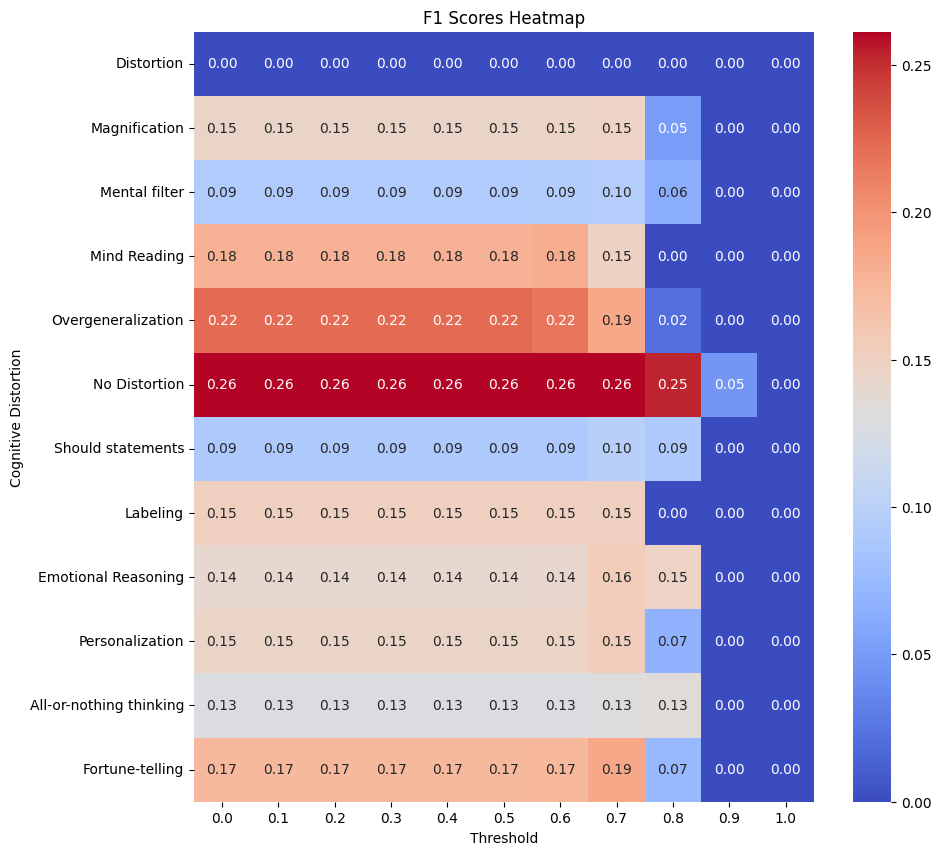

The average F1 score value for a threshold of 0.5 across all distortions for combination 1: 0.1441066167529319
CREATE MODEL
ANALYSE CFCF


C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:204: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

MODEL COMPARISON


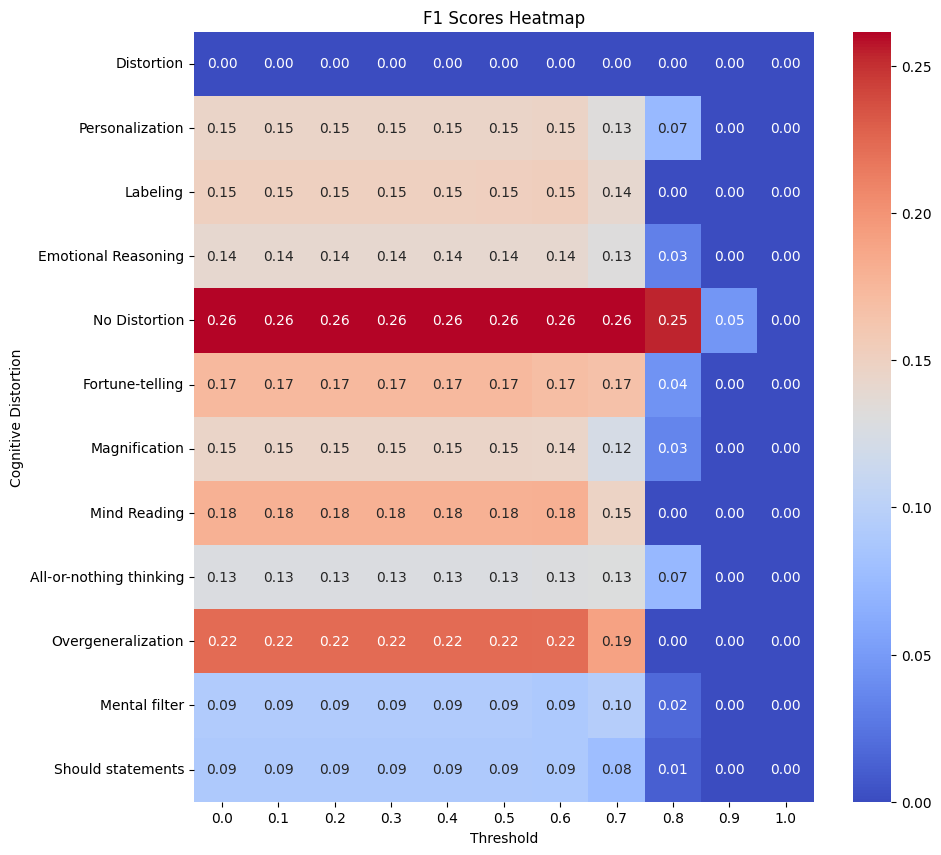

The average F1 score value for a threshold of 0.5 across all distortions for combination 2: 0.14420270071842692
CREATE MODEL
ANALYSE CFCF


C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:204: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1] if pd.notna(row[1]) else row[0]
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  primary_distortion = row[2]  # The primary cognitive distortion from the 3rd column
C:\Users\kzvau\AppData\Local\Temp\ipykernel_9244\424119986.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

MODEL COMPARISON


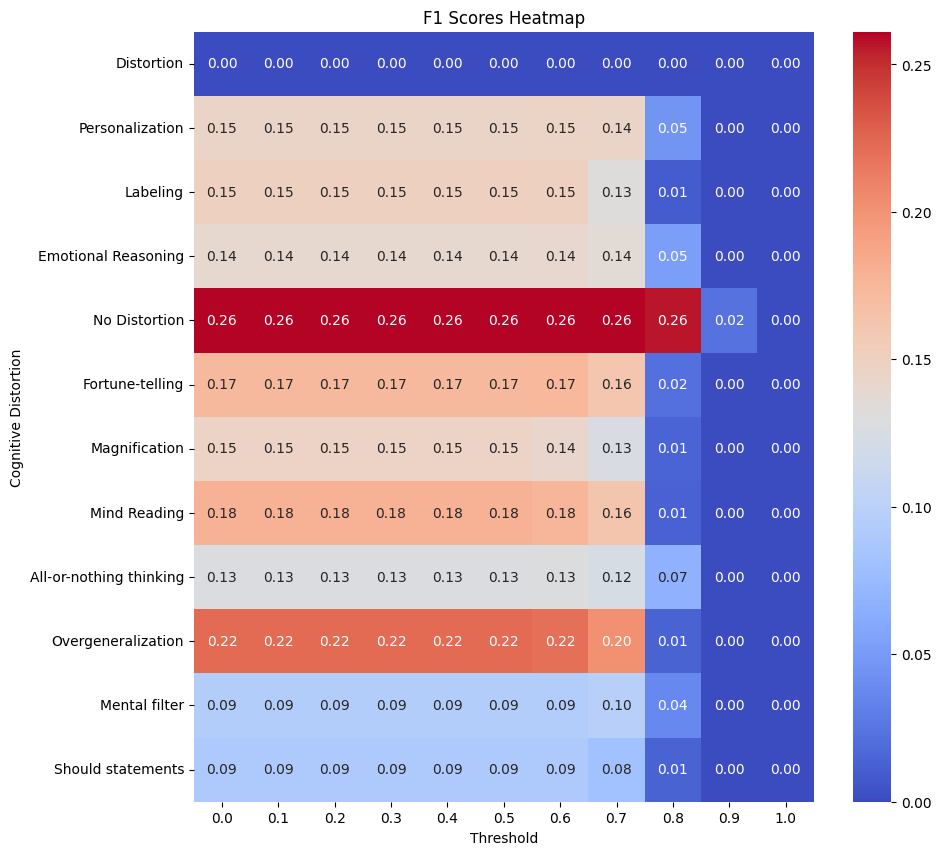

The average F1 score value for a threshold of 0.5 across all distortions for combination 3: 0.14440208523608167


In [9]:
analyse_dataset('CFCF_cf', 4, 20, 3, df)

In [8]:
"""
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
df = pd.read_csv(r"./data/corpora/English/distortions/sagarikashreevastava/test.csv")
df = df.drop('Id_Number', axis=1) # delete columnb with id 

from pygents.aigents_api import TextMetrics
import numpy as np

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = './data/corpora/English/distortions/our model/keywods for our model/' + m + '.txt'
    return metrics


labels = ['Fortune-telling','Personalization', 'No Distortion']
l = TextMetrics(language_metrics(labels),debug=False)

metric_to_index_and_column = {
    label: (i, label) for i, label in enumerate(labels)
}
columns_values = np.zeros((len(df), len(metric_to_index_and_column)))
texts = df['Patient Question'] 

for i, t in enumerate(texts):
    metrics = l.get_sentiment_words(t)
    for metric_name, metric in metrics.items():
        index, _ = metric_to_index_and_column[metric_name]
        columns_values[i][index] = metric

for _, (index, column_name) in metric_to_index_and_column.items():
    our_column_name = f"Our {column_name}"
    their_column_name = f"Their {column_name}"
    df[our_column_name] = pd.Series(columns_values[:, index])
    df[their_column_name] = 0  # Fill "Their" columns with zeros

# Update "Their" columns based on Dominant and Secondary Distortions
for i, row in df.iterrows():
    dominant_distortion = row.get('Dominant Distortion', None)
    secondary_distortion = row.get('Secondary Distortion (Optional)', None)
    
    for _, (_, column_name) in metric_to_index_and_column.items():
        their_column_name = f"Their {column_name}"
        if dominant_distortion == column_name or secondary_distortion == column_name:
            df.at[i, their_column_name] = 1

# Calculate F1 scores for thresholds
thresholds = np.arange(0, 1.1, 0.1)  # Thresholds from 0 to 1 with step 0.1
f1_scores = pd.DataFrame(index=labels, columns=thresholds)

for column_name in labels:
    our_column_name = f"Our {column_name}"
    their_column_name = f"Their {column_name}"
    for threshold in thresholds:
        # Binarize "Our" column based on the threshold
        our_binary = (df[our_column_name] >= threshold).astype(int)
        their_binary = df[their_column_name]
        # Calculate F1 score
        f1 = f1_score(their_binary, our_binary, zero_division=0)
        f1_scores.at[column_name, threshold] = f1
        

# Display the F1 scores as a heatmap
plt.figure(figsize=(8, 2))

# Format thresholds for better readability
formatted_thresholds = [f"{th:.1f}" for th in thresholds]
f1_scores.columns = formatted_thresholds

sns.heatmap(f1_scores.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("F1 Scores Heatmap")
plt.xlabel("Threshold")
plt.ylabel("Cognitive Distortion")

# Adjust the x-axis labels to be horizontal
plt.xticks(rotation=0)

plt.show()

threshold_05 = f1_scores['0.5'].astype(float)
average_f1_05 = threshold_05.mean()
print(f"The average F1 Score value for a threshold of 0.5 across all distortions: {average_f1_05:.3f}")
"""

'\nimport os, sys\ncwd = os.getcwd()\nproject_path = cwd[:cwd.find(\'pygents\')+7]\nif project_path not in sys.path: sys.path.append(project_path)\nos.chdir(project_path)\nfrom sklearn.metrics import f1_score\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nimport pandas as pd\ndf = pd.read_csv(r"./data/corpora/English/distortions/sagarikashreevastava/test.csv")\ndf = df.drop(\'Id_Number\', axis=1) # delete columnb with id \n\nfrom pygents.aigents_api import TextMetrics\nimport numpy as np\n\ndef language_metrics(metrics_list):\n    metrics = {}\n    for m in metrics_list:\n        metrics[m] = \'./data/corpora/English/distortions/our model/keywods for our model/\' + m + \'.txt\'\n    return metrics\n\n\nlabels = [\'Fortune-telling\',\'Personalization\', \'No Distortion\']\nl = TextMetrics(language_metrics(labels),debug=False)\n\nmetric_to_index_and_column = {\n    label: (i, label) for i, label in enumerate(labels)\n}\ncolumns_values = np.zeros((len(df), len(metric_to_index_